<a href="https://colab.research.google.com/github/acse-yl27218/cherry/blob/master/cw_acse8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Name: Liao Yihang
### CID: 01329879

In [1]:
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 573kB 22.3MB/s 
Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#### Provided imports (add more you need them)

In [61]:
import random
import progressbar
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from torchvision import models, datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from livelossplot import PlotLosses
from sklearn.model_selection import StratifiedShuffleSplit

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## 1-Prepare your LeNet-5 network [10 points]
Use the code provided in the Jupyter Notebook template and modify it as you see fit to be able to perform a forward pass using the single dummy tensor input `x` provided. The lines of code that will do the forward pass and print the network are provided in the template.

In [62]:
#make modifications in the code below
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.c1 = nn.Conv2d(3, 6, kernel_size=5, stride=1) 
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)   
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)   
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Linear(16*5*5, 120)    
        self.f6 = nn.Linear(120, 84)   
        self.output = nn.Linear(84, 10)  
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.c1(x))    
        x = self.act(self.s2(x))   
        x = self.act(self.c3(x))   
        x = self.act(self.s4(x))    
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))     
        x = self.act(self.c5(x))       
        x = self.act(self.f6(x))    
        return self.output(x)
    
x = torch.randn((1, 3, 32, 32))
model = LeNet5()
y = model(x)
print(model)
print(y)

LeNet5(
  (c1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
)
tensor([[ 0.0495,  0.0376,  0.0190, -0.0731,  0.0540, -0.0438,  0.0917,  0.1205,
         -0.0749,  0.0543]], grad_fn=<AddmmBackward>)


## 2-Load CIFAR-10 [10 points]
Use `torchvision.datasets.CIFAR10` to load the CIFAR-10 dataset (training and test sets).

In [63]:
# your code goes here
train_dataset = datasets.CIFAR10('./data',train=True,download=True)
test_dataset = datasets.CIFAR10('./data',train=False,download=True)

Files already downloaded and verified
Files already downloaded and verified


## 3-Plot data [5 points]
Plot 25 images of the training set together with their corresponding label names.

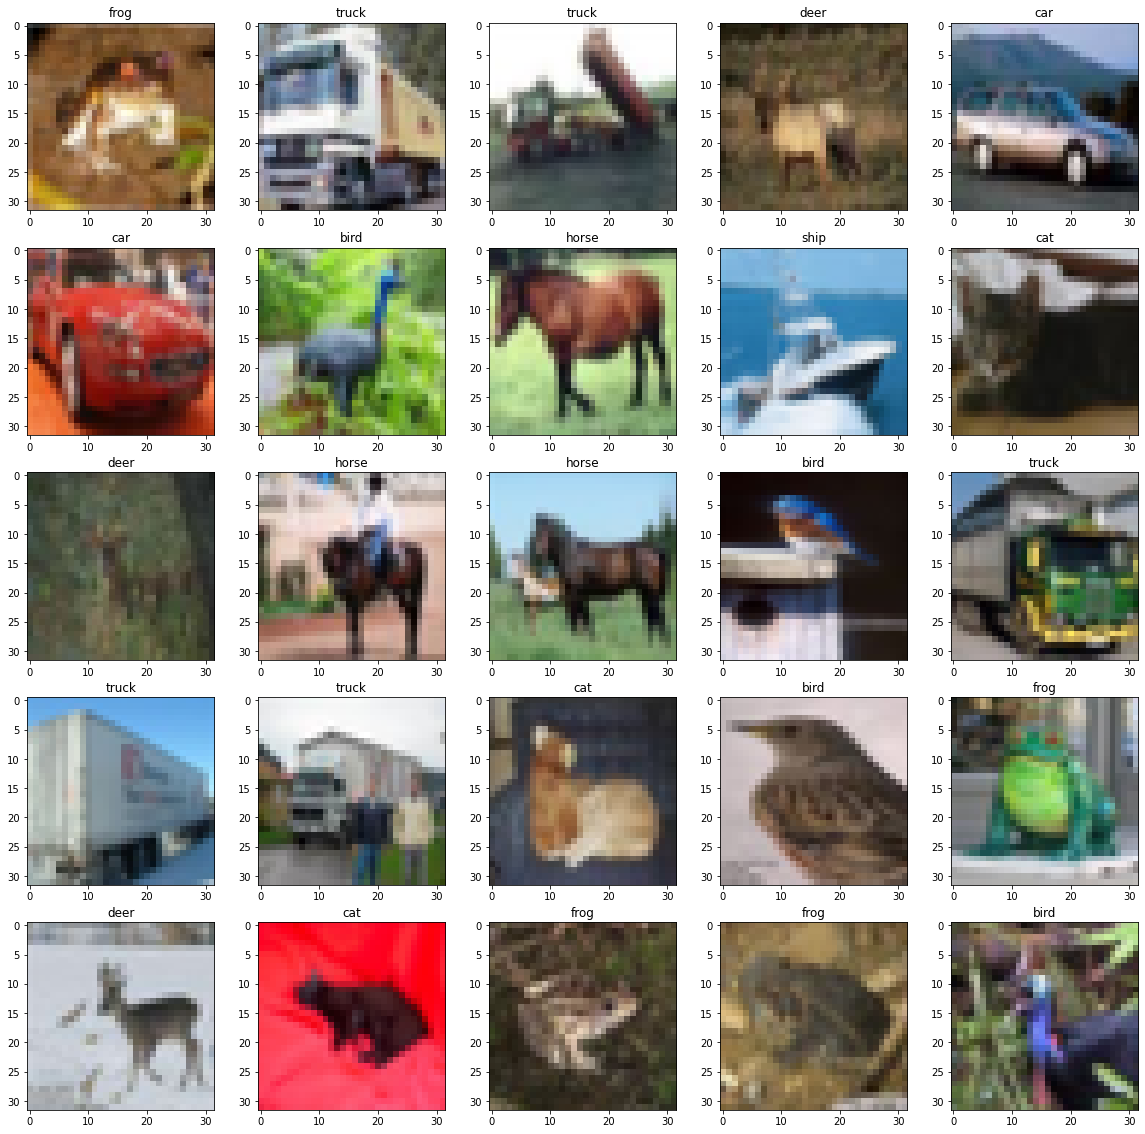

In [64]:
class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(inp,classes, title=None):

    fig = plt.figure(figsize=(20, 20))
    
    """
    Imshow for Tensor.
    """
    for i in range(1,26):
      ax = fig.add_subplot(5,5,i)
      plt.imshow(inp[i-1])
      ax.set_title(class_names[classes[i-1]])


inputs = train_dataset.data[:25]
target = train_dataset.targets[:25]

imshow(inputs,target,title= [class_names[x] for x in target])

## 4-Create a training, validation split [5 points]
Split the data using `sklearn.model\_selection.StratifiedShuffleSplit`:

- 90\% of the data in the training set
- 10\% of the data in the validation set

Prepare the downloaded datasets to be used with your modified network in **1-Prepare your LeNet-5 network**

In [65]:
#stratifiedshufflesplit
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(train_dataset.data, train_dataset.targets) 
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]


x_train, y_train = torch.tensor(train_dataset.data)[indices[0]],torch.tensor(train_dataset.targets)[indices[0]]
x_validation, y_validation = torch.tensor(train_dataset.data)[indices[1]],torch.tensor(train_dataset.targets)[indices[1]]

x_test,y_test = torch.tensor(test_dataset.data),torch.tensor(test_dataset.targets)


#datasets
CIFAR10_train = TensorDataset(x_train.float(), y_train.long())
CIFAR10_validate = TensorDataset(x_validation.float(), y_validation.long())
CIFAR10_test = TensorDataset(x_test.float(), y_test.long())

## 5-Grid search [20 points]
From  the  list  below,  select  two  hyperparameters  and  perform  a  2D  grid-search  to  find  the  optimal values for these two hyperparameters.  The range of values to test are provided.  Justify your choice of the two hyperparameters you want to tune (write a paragraph in a markdown cell explaining why you chose these two particular parameters). 

The list of hyperparameters to choose from is:

a)  Random Number Seed:  **42**  [31, 42, 53] \
b)  Learning Rate:  **1e-2**  [1e-1, 1e-2, 1e-3] \
c)  Momentum:  **0.5**  [0.2, 0.5, 0.8] \
d)  Batch Size:  **64**  [64, 128, 640] \
e)  Number of epochs:  **30**  [10, 30, 50]

The **values in bold** next to each hyperparameter are the values you need to use if you are not tuning this particular hyperparameter.  The values between square brackets are the values to use if you choose to tune this particular hyperparameter. Fixed hyperparameters:

- Optimiser:SGD+momentum
- Test batch size:1000

Write the results in two tables (one for the loss and one for the accuracy) where the columns and rows are the first and second hyperparameter have selected. You can use markdown tables or create the table in python.

You don’t need to plot all the livelossplotplots for each combination you try, as the results will be summarised in the table, but at least plot two of the grid-search runs. 

Select the best values for the two hyperparameters you have chosen to optimise and **justify your choice**.

In [67]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0., 0.
    for X, y in data_loader:
      #calculates l2 norm
      l2_norm = 0.
      for param in model.parameters():
        l2_norm += torch.sum(abs(param)**2)
      
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      a2 = model(X.view(-1, 3, 32, 32))

      #adds l2 norm to the train
      loss = criterion(a2, y) + 1e-4*l2_norm
      loss.backward()
      train_loss += loss*X.size(0)
    
      y_pred = F.log_softmax(a2, dim=1).max(1)[1]

      train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
      optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
      with torch.no_grad():
        X, y = X.to(device), y.to(device)
        a2 = model(X.view(-1, 3, 32, 32))
        loss = criterion(a2, y)
        validation_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
      with torch.no_grad():
        X, y = X.to(device), y.to(device)
        a2 = model(X.view(-1, 3, 32, 32))
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        ys.append(y.cpu().numpy())
        y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

# hyperparameters
momentum = [0.2,0.5,0.8]
lr = [1e-1,1e-2,1e-3]

seed = 42
batch_size = 64
epochs = 30
test_batch_size = 1000

In [68]:
def train_model(momentum,lr):
    set_seed(seed)
    model = LeNet5()
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(CIFAR10_train, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(CIFAR10_validate, batch_size=test_batch_size, shuffle=True)

    train_los = []
    train_acc = []
    val_los = []
    val_acc = []


    for epoch in range(30):
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
        train_los.append(train_loss.item())
        train_acc.append(train_accuracy.item())

        validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
        val_los.append(validation_loss.item())
        val_acc.append(validation_accuracy.item())

    return model,(train_los,train_acc,val_los,val_acc)

In [ ]:
res = []
for i in momentum:
  for j in lr:
    res.append(train_model(i,j)[1])

In [ ]:
"""
focusing on the final train and validation accuracy after 30 epochs
"""

for i in range(len(momentum)):
  for j in range(len(lr)):
    print('momentumn: {}, learning_rate: {}, validation accuracy: {}, train_accuracy: {}'.format(momentum[i],lr[j],res[int(i*len(lr) + j)][-1][-1],res[int(i*len(lr) + j)][1][-1]))

In [42]:
def train_withplots(lr):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)
  criterion = nn.CrossEntropyLoss()

  train_loader = DataLoader(CIFAR10_train, batch_size=batch_size, shuffle=True)
  validation_loader = DataLoader(CIFAR10_validate, batch_size=test_batch_size, shuffle=True)
  

  liveloss = PlotLosses()

  for epoch in range(30):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

  return model

live_plots for learning rate = 0.1, 0.01, 0.001 and with constant momentum 0.5

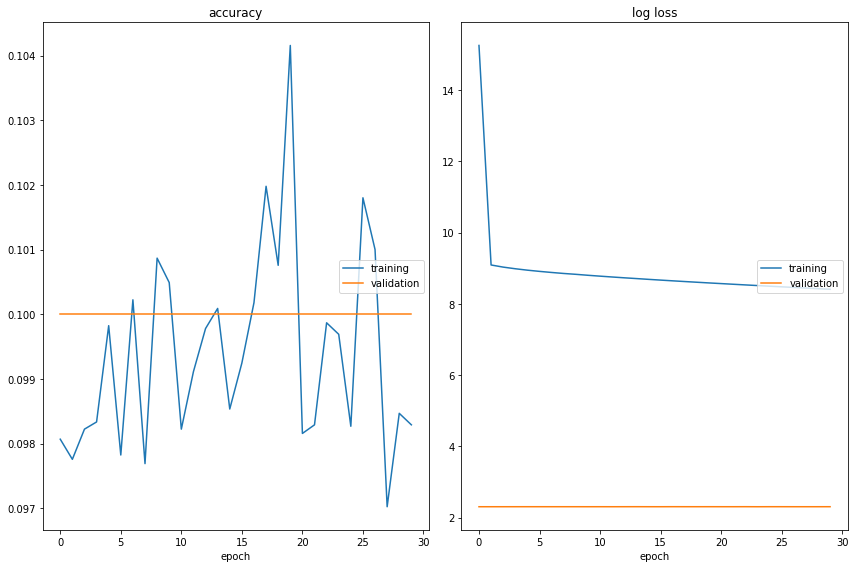

accuracy
	training         	 (min:    0.097, max:    0.104, cur:    0.098)
	validation       	 (min:    0.100, max:    0.100, cur:    0.100)
log loss
	training         	 (min:    8.410, max:   15.257, cur:    8.410)
	validation       	 (min:    2.303, max:    2.304, cur:    2.303)


In [43]:
model = train_withplots(0.1)

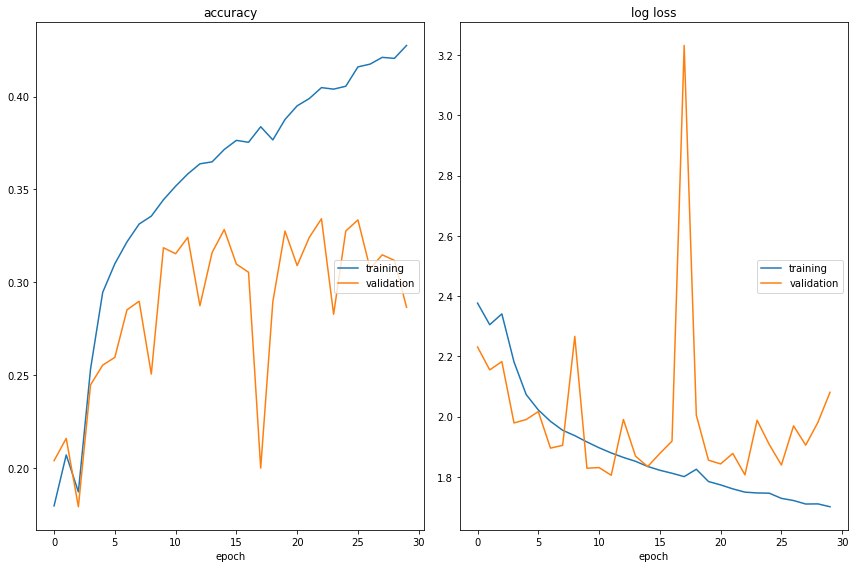

accuracy
	training         	 (min:    0.180, max:    0.427, cur:    0.427)
	validation       	 (min:    0.179, max:    0.334, cur:    0.287)
log loss
	training         	 (min:    1.701, max:    2.377, cur:    1.701)
	validation       	 (min:    1.805, max:    3.232, cur:    2.081)


In [44]:
model = train_withplots(0.01)

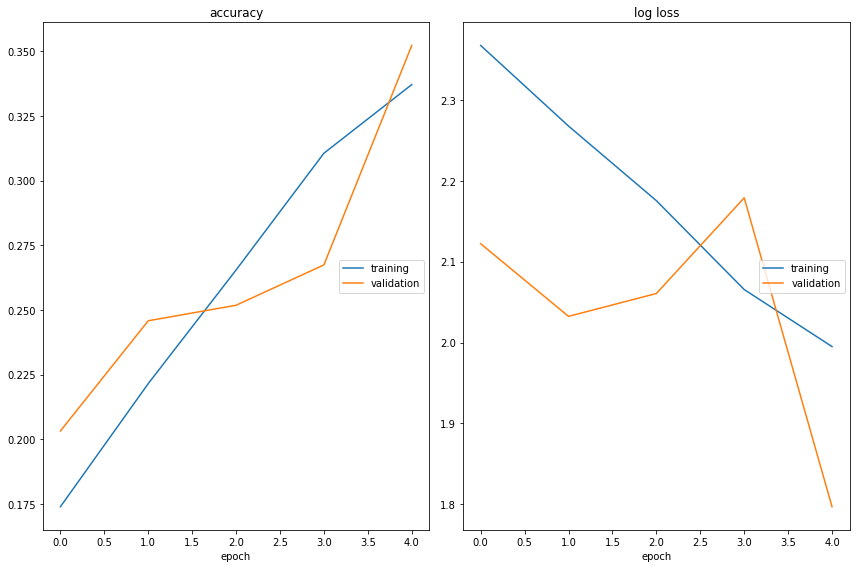

accuracy
	training         	 (min:    0.174, max:    0.337, cur:    0.337)
	validation       	 (min:    0.203, max:    0.352, cur:    0.352)
log loss
	training         	 (min:    1.995, max:    2.367, cur:    1.995)
	validation       	 (min:    1.797, max:    2.179, cur:    1.797)


KeyboardInterrupt: ignored

In [46]:
model = train_withplots(0.001)


## 6-Train with best hyperparameters [5 points]

Once you have your two best hyperparameters, retrain the model by combining the validation, training, and test sets as you see fit. Report the final accuracy on the test set. Use `livelossplot` to plot the values of the training evolution.

In [ ]:
def train_model(momentum,lr):
    set_seed(seed)
    model = LeNet5().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_all, batch_size=batch_size, shuffle=True, num_workers=0)
    
    test_loader = DataLoader(CIFAR10_test, batch_size=test_batch_size, shuffle=True, num_workers=0)
    

    liveloss = PlotLosses()

    for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, test_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()

    return model

x_all, y_all = torch.tensor(train_dataset.data),torch.tensor(train_dataset.targets)
train_all = TensorDataset(x_all.float(), y_all.long())

train_model(0.8, 0.001)

## 7-Answer the following questions [1 point each]
Which of these data-augmentation transforms would be reasonable to apply to CIFAR10 and why? 

1. Left-Right Flips
2. Random Rotations by up to 10 Degrees
3. Up-Down Flips
4. Shifting up-down, left-right by 5 pixels
5. Contrast Changes
6. Adding Gaussian Noise
7. Random Rotations by up to 90 Degrees

Justify each one of your answers.

---

Write your answers here:

1. yes, left right flips changes the images
2. no, 10 degrees apply in 32*32 images, the angle rotates maybe too small
3. yes, up down filps changes the images
4. yes, 32*32, shifting up-down and left-right may be resonable
5. yes, changing the contrast is a reasonable data augmentation
6. no, since the resolutions of cifar10 are relatively small, adding guassian noise may make it strange and much harder to be classified even by eye.
7. yes, rotates up to 90 degrees will be reasonables.



## 8-Plot augmented data [13 points]

Select one of the data-augmentation transforms you decided were reasonable in the previous question. Implement it, and apply it to 9 images of the CIFAR-10 dataset.

Plot the 9 transformed images.

In [ ]:
transform = transforms.Compose([
    # resize
    transforms.Resize(32),
    # center-crop
    transforms.CenterCrop(32),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
#apply transform and load
train_dataset = datasets.CIFAR10('./data',train=True, download=True)
test_dataset = datasets.CIFAR10('./data',train=False, download=True)

class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#transforming 9 images

## 9-Visualising loss landscapes paper [10 points]

Read the provided paper [Visualising the Loss Landscape of Neural Nets](https://arxiv.org/pdf/1712.09913.pdf).

This paper is contains a lot of advanced concepts. You only need to read and understand it well up to, and including, section 4, (Proposed Visualization: Filter-Wise Normalisation) to answer the questions below. In section 4 you don't need to fully understand the rationale for doing Filter-Wise Normalisation, but you do need to understand what Filter-Wise Normalisation is.

Answer the following questions (in a markdown cell):

1. What are $\delta$, $\eta$, $\alpha$ and $\beta$ in equation (1)? [5 points]
2. What does Filter-Wise Normalisation do? [5 points] Don't need to explain the reasons for doing it, just how it modifies the random directions $\delta$ and $\eta$. 

Explain well and justify your answers. **(Don't answer in 1. that $\delta$ is a random direction just because it says that in 2. Explain what is meant by a random direction well.)**

---

Write you answers here:

1. 


2. 



## 10-Visualise loss landscape [15 points]

Use the formula described in equation (1) in the paper in combination with the Filter-Wise Normalisation to generate landscape plots. For that use your final trained model (output of question **7**) and 25 values for $\alpha$ and 25 values for $\beta$ to generate a 2D plot with a 100 points. Use the provided snippets of code in the Jupyter Notebook template to assist you in generating the plots and to guide you in the functions you will need to implement (not mandatory, you can implement everything from scratch if you prefer).

Note that in this question you will not be comparing the smoothness of different loss landscapes (as they do in the paper), you will only be plotting the loss function landscape around the loss value corresponding to your trained network.



In [ ]:
# The following snippets of code are only to assist you. You can decide to use 
# them or not. They are only intended to provide you with some functionality
#  you may find useful when trying to generate the loss landscape plots.


# function to create random directions:
def create_random_directions(weights, ignore1D=False, seed=42):
    torch.manual_seed(seed)
    direction = [torch.randn(w.size()).to(device) for w in weights]
    
    # apply filter normalisation, where every perturbation d in direction has the same norm as its corresponding w in weights
    for d, w in zip(direction, weights):
        if ignore1D and d.dim() <= 1:
            d.fill_(0)
        d.mul_(w.norm()/(d.norm() + 1e-10)) # add small perturbation to avoid division by zero

    return direction


# function to update weigths
def update_weights(model, origin_weights, x_dir, y_dir, dx=0.1, dy=0.1):
    updates = [x.to(device)*dx + y.to(device)*dy for (x, y) in zip(x_dir, y_dir)]
    for (p, w, u) in zip(model.parameters(), origin_weights, updates):
        p.data = w + u
    return None


# function to plot loss landscape as a surface
def plot_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(8, 8),subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(xx, yy, loss_landscape, cmap='viridis', edgecolor='none',
                       linewidth=0, antialiased=True,  rstride=1, cstride=1,)
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    ax.set_zlabel(r'Loss')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


# function to plot loss landscape as a contour
def contour_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(7, 7))
    surf = ax.contourf(xx, yy, loss_landscape, cmap='viridis', levels=100)
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


# BONUS: functions to compute the angle between 2 random vectors
# in high-dimensional spaces two random vectors are quite likely to be
# orthogonal (or almost). No points involved here, this is just for fun!
#
def angle(vec1, vec2):
    return torch.acos(torch.dot(vec1, vec2)/(vec1.norm()*vec2.norm())).item()

def rad2deg(angle):
    return angle*180/np.pi

def concat_torch_list(torch_list):
    for i, t in enumerate(torch_list):
        torch_list[i] = t.flatten()
    return torch.cat(torch_list)

In [ ]:
# your code here

### 10-(continued)

Discuss your results, and justify the choices you make along the generation process of plotting the loss landscapes (for example the range your choose for your $\alpha$ and $\beta$ values).

---

Write your answers here: